# Abstract

This blog post examines the fairness and accuracy of a machine learning model designed to predict employment status in Missouri using demographic data. By auditing for bias, the analysis assesses disparities in prediction accuracy, false positive rates, and false negative rates across racial groups. The results indicate that the model meets calibtration and statistical parity, but fails to meet error rate balance. The study also explores potential ethical and practical concerns, such as privacy risks, model reliability, and unintended consequences in commercial and governmental applications. Recommendations for mitigating these risks include implementing strict data privacy measures, incorporating human oversight, regularly auditing the model, and ensuring transparency in decision-making processes.

# Data Preparation and Package Installation

Loading the ACS data from Missouri and selecting the features we want to train on.

In [58]:
import warnings
warnings.filterwarnings('ignore')
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "MO"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

# filte the data to only use recommended features
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,27,17.0,5,16,2,NaN,1,3.0,4.0,4,1,2,2,2.0,2,1,6.0
1,42,19.0,5,16,2,NaN,1,3.0,4.0,1,1,2,2,2.0,1,2,6.0
2,20,19.0,5,17,2,NaN,1,1.0,4.0,2,1,2,2,2.0,1,1,1.0
3,26,17.0,5,16,1,NaN,1,1.0,4.0,1,1,2,2,1.0,1,2,6.0
4,37,16.0,5,16,1,NaN,1,3.0,4.0,1,1,2,1,1.0,1,2,6.0


Transforming the features into a basic problem to address the task of predicting employment status while excluding race as a demographic.

In [59]:
# subset the features we want to use
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

# construct a basic problem to predict employment status without considering race
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

# separate into a feature matrix, label vector, and a group label vector
features, label, group = EmploymentProblem.df_to_numpy(acs_data)

Split into a training and test split.

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

# Assessing Initial Variance

Lets now look at some basic descriptives.

There are 49932 individuals in the dataset 

There are 22306 individuals in the dataset are currently employed 

The number of individuals in each group: 
group
1    43713
2     3838
3      150
4        5
5       27
6      762
7       51
8      316
9     1070
dtype: int64

The proportion of individuals in each group that are currently employed: 
group
1    0.454396
2    0.395779
3    0.460000
4    0.600000
5    0.407407
6    0.493438
7    0.529412
8    0.373418
9    0.299065
Name: label, dtype: float64


Text(0, 0.5, 'Proportion Employed')

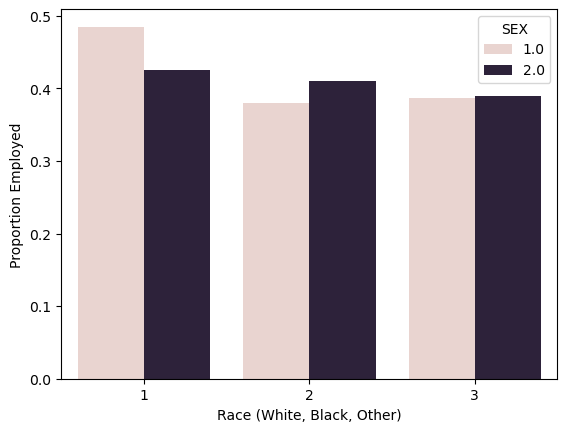

In [61]:
import pandas as pd
import seaborn as sns

# convert the data back into a dataframe to make it easier to work with
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train

# how many individuals are there in the data
print("There are " + str(len(df)) + " individuals in the dataset \n")

# how many individuals are currently employed
print("There are " + str(len(df[df["label"] == 1])) + " individuals in the dataset are currently employed \n")

# how many individuals in each group
print("The number of individuals in each group: ")
print(df.groupby("group").size())

# proportion of individuals in each group that are currently employed
print("\nThe proportion of individuals in each group that are currently employed: ")
print(df.groupby("group")["label"].mean())

# lets now add sex to the consideration of race and proportion predicted to be employed
df["group"][df["group"] > 2] = 3
ax = sns.barplot(data = df, x = "group", y = "label", hue = "SEX", errorbar = None)
ax.set_xlabel("Race (White, Black, Other)")
ax.set_ylabel("Proportion Employed")

While there is some variance across sex and race in the employment rate, for the most part the employment rate is approximately equal across all groups. Although both white females and males are more employed more than any other subgroup. 

# Training a Model

Lets train a model using a decision tree classifier with an optimal model complexity. Select model complexity based on the complexity that gets the higest accuracy and the lowest standard deviation.

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# assess 50 model complexities

complexity = []

for i in range(1, 50, 1):
    # fit a model with the given complexity
    m = DecisionTreeClassifier(max_depth = i)
    m.fit(X_train, y_train)

    # assess accuracy
    test_hat = m.predict(X_test)
    test_acc = (test_hat == y_test).mean()

    # store this result
    complexity.append((test_acc, i))

complexity.sort(reverse = True)

print("Purely by accuracy, the best five model complexities are: " + str(complexity[:5]))


Purely by accuracy, the best five model complexities are: [(0.8406760653636655, 7), (0.8405158603011855, 9), (0.8398750400512656, 8), (0.8397148349887856, 10), (0.8393143223325857, 6)]


Assess these models to find which one is most consistent by checking with cross validation.

In [63]:
from sklearn.model_selection import cross_val_score

# pull out the top 5 complexities
best_complexity = []
for comp in complexity:
    best_complexity.append(comp[1])

best_complexity = best_complexity[:5]
best_comp = 0
best_std = float("inf")

# assess which of the best complexities has the lowest standard deviation in cross validation
for comp in best_complexity:
    # fit the model
    m = DecisionTreeClassifier(max_depth = comp)
    m.fit(X_train, y_train)

    # assess cross validation
    cv_scores = cross_val_score(m, X_train, y_train, cv = 5)
    std = np.std(cv_scores)

    if std < best_std:
        best_std = std
        best_comp = comp

print("The model complexity that minimizes standard devition is: " + str(best_comp) + " with a standard deviation of: " + str(best_std))

The model complexity that minimizes standard devition is: 6 with a standard deviation of: 0.003064476956674178


Lets now fit the model using our optimal depth into our pipeline.

In [64]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# fit the model into our pipeline

model = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth = best_comp))
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=6))])

In [65]:
# pull predictions from the model based on the test data
y_hat = model.predict(X_test)

# assess the model's overall predicitve accuracy
print("The overall testing accuracy is: " + str((y_hat == y_test).mean()))

# asses the model's predictive accuracy for white individuals
print("The testing accuracy for white individuals is: " + str((y_hat == y_test)[group_test == 1].mean()))

# assess the model's predicitve accuracy for black individuals
print("The testing accuracy for black individuals is: " + str((y_hat == y_test)[group_test == 2].mean()))

# assess the model's predicitve accuracy for others
print("The testing accuracy for other racial groups is: " + str((y_hat == y_test)[group_test == 3].mean()))

The overall testing accuracy is: 0.8393143223325857
The testing accuracy for white individuals is: 0.8399193178692582
The testing accuracy for black individuals is: 0.8356605800214822
The testing accuracy for other racial groups is: 0.8421052631578947


The model has an approximately equal prediction rate for employment status across racial groups. In this model white individuals are the least likely to be predicted as employed, black individuals are slightly more likely, and members of all other racial groups are more likely as a whole. Lets now look at the positive predictive value as well as the false negative and false positive rates of the model. 

In [66]:
# calculate the overall accuracy of the model
print("The overall accuracy of the model at predicting employment status is: " + str((y_hat == y_test).mean()))

# calculate the overall PPV
TP = np.sum((y_hat == y_test) & (y_hat == 1))
FP = np.sum((y_hat != y_test) & (y_hat == 1))
PPV = TP / (TP + FP)
print("The overall positive predictive value of our model is: " + str(PPV))

# calculate the overall FNR
FN = np.sum((y_hat != y_test) & (y_hat == 0))
FNR = FN / (FN + TP)
print("The overall false negative rate of our model is: " + str(FNR))

# calculate the overall FPR
TN = np.sum((y_hat == y_test) & (y_hat == 0))
FPR = FP / (FP + TN)
print("The overall false positive rate of our model is: " + str(FPR))

The overall accuracy of the model at predicting employment status is: 0.8393143223325857
The overall positive predictive value of our model is: 0.802518223989397
The overall false negative rate of our model is: 0.1438670908448215
The overall false positive rate of our model is: 0.17462642836214473


Now lets look at these statistics broken down by group.

In [67]:
# calculate the model's accuracy of predicting employment status for white, black and othe racial groups
print("The model's accuracy of predicting employment status for white individuals is: " + str((y_hat == y_test)[group_test == 1].mean()))
print("The model's accuracy of predicting employment status for black individuals is: " + str((y_hat == y_test)[group_test == 2].mean()))
print("The model's accuracy of predicting employment status for other individuals is: " + str((y_hat == y_test)[group_test > 2].mean()) + "\n")

# calculate the PPV for white, black, and other racial groups
# white individuals
TP_W = np.sum((y_hat == y_test)[group_test == 1] & (y_hat == 1)[group_test == 1])
FP_W = np.sum((y_hat != y_test)[group_test == 1] & (y_hat == 1)[group_test == 1])
PPV_W = TP_W / (TP_W + FP_W)
print("The positive predictive value for white individuals in our model is: " + str(PPV_W))

# black individuals
TP_B = np.sum((y_hat == y_test)[group_test == 2] & (y_hat == 1)[group_test == 2])
FP_B = np.sum((y_hat != y_test)[group_test == 2] & (y_hat == 1)[group_test == 2])
PPV_B = TP_B / (TP_B + FP_B)
print("The positive predictive value for black individuals in our model is: " + str(PPV_B))

# other individuals
TP_O = np.sum((y_hat == y_test)[group_test > 2] & (y_hat == 1)[group_test > 2])
FP_O = np.sum((y_hat != y_test)[group_test > 2] & (y_hat == 1)[group_test > 2])
PPV_O = TP_O / (TP_O + FP_O)
print("The positive predictive value for other individuals in our model is: " + str(PPV_O) + "\n")

# calculate the FNR for white, black, and other racial groups
# white individuals
FN_W = np.sum((y_hat != y_test)[group_test == 1] & (y_hat == 0)[group_test == 1])
FNR_W = FN_W / (FN_W + TP_W)
print("The false negative rate for white individuals in our model is: " + str(FNR_W))

# black individuals
FN_B = np.sum((y_hat != y_test)[group_test == 2] & (y_hat == 0)[group_test == 2])
FNR_B = FN_B / (FN_B + TP_B)
print("The false negative rate for black individuals in our model is: " + str(FNR_B))

# other individuals
FN_O = np.sum((y_hat != y_test)[group_test > 2] & (y_hat == 0)[group_test > 2])
FNR_O = FN_O / (FN_O + TP_O)
print("The false negative rate for other individuals in our model is: " + str(FNR_O) + "\n")

# calculate the FPR for white, black, and other racial groups
# white individuals
TN_W = np.sum((y_hat == y_test)[group_test == 1] & (y_hat == 0)[group_test == 1])
FPR_W = FP_W / (FP_W + TN_W)
print("The false positive rate for white individuals in our model is: " + str(FPR_W))

# black individuals
TN_B = np.sum((y_hat == y_test)[group_test == 2] & (y_hat == 0)[group_test == 2])
FPR_B = FP_B / (FP_B + TN_B)
print("The false positive rate for black individuals in our model is: " + str(FPR_B))

# other individuals
TN_O = np.sum((y_hat == y_test)[group_test > 2] & (y_hat == 0)[group_test > 2])
FPR_O = FP_O / (FP_O + TN_O)
print("The false positive rate for other individuals in our model is: " + str(FPR_O))

The model's accuracy of predicting employment status for white individuals is: 0.8399193178692582
The model's accuracy of predicting employment status for black individuals is: 0.8356605800214822
The model's accuracy of predicting employment status for other individuals is: 0.8343653250773994

The positive predictive value for white individuals in our model is: 0.8082397003745319
The positive predictive value for black individuals in our model is: 0.7468671679197995
The positive predictive value for other individuals in our model is: 0.7744107744107744

The false negative rate for white individuals in our model is: 0.14331083763398175
The false negative rate for black individuals in our model is: 0.14857142857142858
The false negative rate for other individuals in our model is: 0.14814814814814814

The false positive rate for white individuals in our model is: 0.17447606065769297
The false positive rate for black individuals in our model is: 0.1738382099827883
The false positive rate f

Interestingly, across all groups the accuracy, positive predictive value, FNR, and FPR are all extremely similar and displays very little discrepancy from the overall rates. The only thing that could be said is that white individuals have the highest PPV, other indivudals a slightly lower PPV, and black individuals having the clear lowest PPV. Based on the information above, this implies that our model is well - calibrated as the algorithim is aproximately equally likely to predict white, black, and other individuals to be employed. The false negative rate is approximately equal across racial groups and the false positive rate is also approximately equal across racial groups; however, the false positive rates are not equal to the false negative rates and our model fails to meet error rate balance. Because our data is binary, and the proportion of individuals in each group predicted to be employed is approximately equal, statistical parity is met for our model. Thus our model can be considered reasonably fair. 

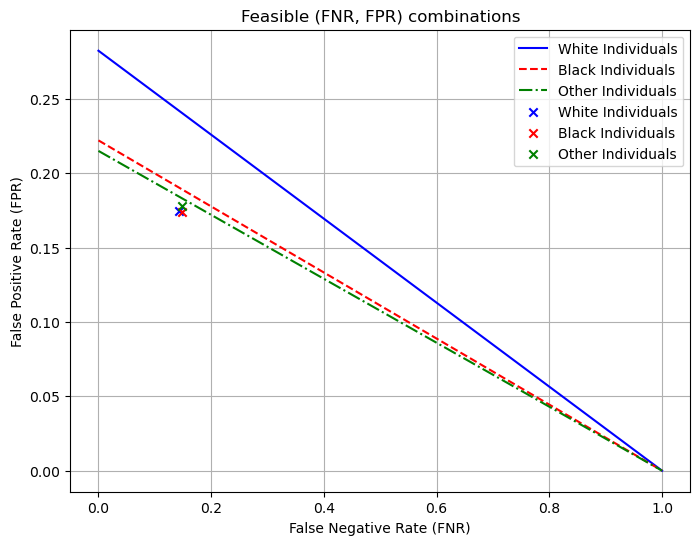

In [81]:
import matplotlib.pyplot as plt

# pull out prevalence from the dataset
p_W, p_B, p_O = df.groupby("group")["label"].mean()

# fix the PPV to the lowest of the PPV across groups
PPV_fixed = min(PPV_W, PPV_B, PPV_O)

# function to compute FPR given FNR based on eqn 2.6
def compute_FPR(fnr, p, ppv_fixed):
    return (p / (1 - p)) * ((1 - ppv_fixed) / ppv_fixed) * (1 - fnr)

# Generate FNR-FPR tradeoff curves for each group
fnr_range = np.linspace(0, 1, 100)
fpr_W_curve = compute_FPR(fnr_range, p_W, PPV_fixed)
fpr_B_curve = compute_FPR(fnr_range, p_B, PPV_fixed)
fpr_O_curve = compute_FPR(fnr_range, p_O, PPV_fixed)

# generate an empty plot
plt.figure(figsize = (8,6))

# plot the feasible trade off curves
plt.plot(fnr_range, fpr_W_curve, color = "blue", label = "White Individuals")
plt.plot(fnr_range, fpr_B_curve, color = "red", label = "Black Individuals", linestyle = "dashed")
plt.plot(fnr_range, fpr_O_curve, color = "green", label = "Other Individuals", linestyle = "dashdot")

# mark the observed (FNR, FPR) values
plt.scatter(FNR_W, FPR_W, color = "blue", label = "White Individuals", marker = "x")
plt.scatter(FNR_B, FPR_B, color = "red", label = "Black Individuals", marker = "x")
plt.scatter(FNR_O, FPR_O, color = "green", label = "Other Individuals", marker = "x")

# Labels and legend
plt.xlabel("False Negative Rate (FNR)")
plt.ylabel("False Positive Rate (FPR)")
plt.title("Feasible (FNR, FPR) combinations")
plt.legend()
plt.grid(True)


To equalize FPR across groups, the FNR for white individuals would need to increase, while the FNR for black and other individuals would need to decrease. The exact amount of change is dependent on the slopes of the curves.

# Discussion

Because our model is relatively fair across all groups, and has reasonable overall predictive accuracy many companies which may want to consider employment status could be imterested. A primary example would be banks seeking to hand out loans; employment status is a great marker of financial stability. Banks would not want to given loans that would be unlikely to receive back, thus they would want to be able to do predict the employment status of the individuals seeking loans.

Deploying this model for large-scale predictions in commercial or governmental settings could influence critical decisions, such as loan approvals, hiring practices, or government assistance distribution. Since the model demonstrates fairness across racial groups and satisfies error rate balance and statistical parity, it reduces the risk of systemic bias in predictions. However, small discrepancies, such as lower positive predictive value for Black individuals, could still lead to disparities in real-world outcomes; this could especially be true in systemically oppressed neighborhoods which have disproportionately higher unemployment rates. This could result in continuing to deny these individuals the resources they need.

Although our model displays error rate balance, the difference is only ~ 3%. This is a small difference and is likely not incredibly harmful. Across all other measures the models is reasonably fair. The only other troubling statistic is the fairly large decrease in PPV for black individuals as opposed to white individuals. 

Beyond bias, several potential issues with deploying this model could raise concerns. First, the model's reliance on demographic data may lead to privacy risks and ethical dilemmas, particularly if sensitive attributes are misused or inferred. Additionally, employment status is dynamic and influenced by economic conditions, meaning the model could become outdated over time. To address these concerns, I would propose several solutions. First, strict data privacy protocols should be in place to ensure that sensitive information is handled securely and used responsibly. Second, human oversight should complement automated decisions, especially in high-stakes scenarios, to prevent over-reliance on imperfect predictions. Third, regular model audits and recalibrations should be conducted to maintain accuracy and fairness as employment patterns and economic conditions shift. Finally, transparency in model deployment is essential—individuals affected by the predictions should have access to explanations and recourse options if they believe they were unfairly assessed.